In [8]:
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Tuple
import json
import numpy as np
import torch
from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from lavis.models import load_model_and_preprocess

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [2]:
@dataclass
class DataUnit:
    image: str
    caption: str
    mask: Tuple[str, int]  # (image, index), where mask = image == index
    prev_image: str
    prev_mask: Tuple[str, int]
    
    def __post_init__(self):
        self.image = str(self.image)
        self.mask = (str(self.mask[0]), self.mask[1])
        self.prev_image = str(self.prev_image)
        self.prev_mask = (str(self.prev_mask[0]), self.prev_mask[1])

### BLIP model for caption

In [3]:
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_vicuna_instruct",
    model_type="vicuna7b",
    is_eval=True,
    device=device,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def get_caption(filename: str):
    image = Image.open(filename).convert("RGB")
    image = vis_processors["eval"](image).unsqueeze(0).to(device)
    caption = model.generate({"image": image})[0]
    return caption

### Data Loading

In [5]:
src_dir = Path("/data/video-dataset/VSPW/")
with open(src_dir / "label_num_dic_final.json", "r") as f:
    label2idx = json.load(f)
idx2label = {idx: label for label, idx in label2idx.items()}

In [6]:
vid = "415_5FjFtNEBX2I"
video_dir = src_dir / "data" / vid
frames = sorted((video_dir / "origin").glob("*.jpg"))
masks = sorted((video_dir / "mask").glob("*.png"))

In [9]:
sample_dataset = []
for prev, curr in tqdm(zip(range(0, len(frames) - 1), range(1, len(frames))), total=len(frames) - 1):
    mask_index = 122
    data_unit = DataUnit(
        image=frames[curr],
        caption=get_caption(frames[curr]),
        mask=(masks[curr], mask_index),
        prev_image=frames[prev],
        prev_mask=(masks[prev], mask_index),
    )
    sample_dataset.append(data_unit)

  0%|          | 0/135 [00:00<?, ?it/s]/home/longc/miniconda3/envs/LAVIS/lib/python3.10/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/home/longc/miniconda3/envs/LAVIS/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
100%|██████████| 135/135 [00:56<00:00,  2.38it/s]


In [15]:
import shutil
import cv2

output_dir = Path("/home/longc/data/code/lora-scripts/config/video-example")
for du in sample_dataset[:2]:
    shutil.copy(du.image, output_dir / "images")
    shutil.copy(du.prev_image, output_dir / "images")

    mask = (np.array(Image.open(du.mask[0])) == du.mask[1]).astype(np.uint8) * 255
    cv2.imwrite(str(output_dir / "masks" / Path(du.mask[0]).name), mask)
    prev_mask = (np.array(Image.open(du.prev_mask[0])) == du.prev_mask[1]).astype(
        np.uint8
    ) * 255
    cv2.imwrite(str(output_dir / "masks" / Path(du.prev_mask[0]).name), prev_mask)

In [11]:
with open(src_dir / "data.jsonl", "w") as f:
    for data_unit in sample_dataset:
        f.write(json.dumps(asdict(data_unit)) + "\n")

### Debug Label

In [38]:
mask = np.array(Image.open(masks[0]))
for idx in np.unique(mask):
    print(idx2label[str(idx)], idx)

pole 13
floor 14
person 61
box 77
tub_or_bowl_or_pot 84
table_or_desk 90
food 122


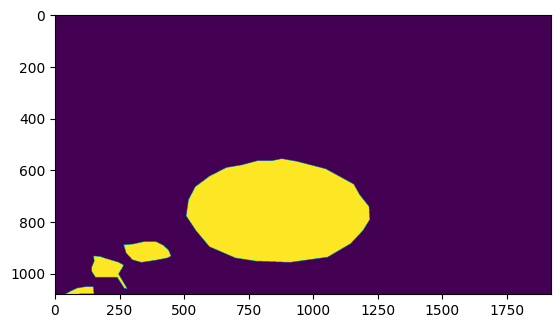

In [43]:
plt.imshow(mask == 122)